It's been reccomended that I switch from Buzzard v1.0 to 1.1. There's a nice catalog that actually has the richnesses and the masses. Huzzah.

In [13]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [14]:
from astropy.io import fits
dataDir = '/home/sean/Data/BuzzardSims/'
hdulist = fits.open(dataDir+'buzzard-v1.1-y5_run_redmapper_v6.4.7_lgt-1_lambda_chisq_catalog.fit')

In [15]:
data = hdulist[1].data
data.columns.info()

name:
    ['HALOID', 'RA', 'DEC', 'Z', 'M200', 'R200', 'MEM_MATCH_ID', 'LAMBDA_CHISQ', 'LAMBDA_CHISQ_E', 'LAMBDA_CHISQ_ZORIG', 'SCALEVAL', 'LAMBDA_ZRED', 'LAMBDA_ZRED_E', 'MASKFRAC', 'GEOMASKFRAC', 'R_LAMBDA', 'R_MASK', 'Z_LAMBDA', 'Z_LAMBDA_E', 'NCROSS', 'Z_LAMBDA_NITER', 'DLAMBDA_DZ', 'DLAMBDA_DZ2', 'DLAMBDAVAR_DZ', 'DLAMBDAVAR_DZ2', 'C_LAMBDA', 'C_LAMBDA_ERR', 'MAG_LAMBDA_ERR', 'PZBINS', 'PZ', 'Z_LAMBDA_RAW', 'Z_LAMBDA_E_RAW', 'P_BCG', 'BCG_SPEC_Z', 'LIM_EXPTIME', 'LIM_LIMMAG', 'LIM_LIMMAG_HARD']
format:
    ['J', 'D', 'D', 'E', 'D', 'D', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'I', 'I', 'E', 'E', 'E', 'E', 'E', '3E', '3E', '4E', '21E', '21E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']
unit:
    ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
null:
    ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 

In [16]:
import numpy as np
logMass = np.log10(data['M200'])
rich = data['LAMBDA_CHISQ']
logRich = np.log10(rich)

#sns.jointplot(rich, logMass, kind = 'kde', space = 0, stat_func = None)

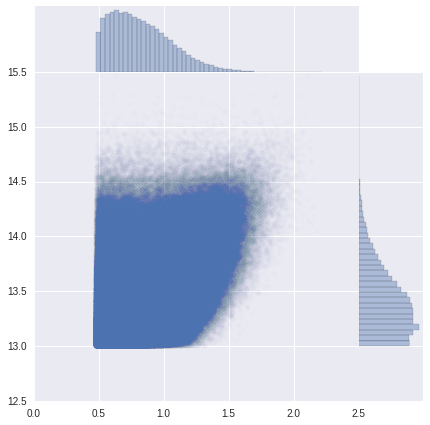

In [23]:
sns.jointplot(logRich, logMass, kind = 'scatter', space = 0, stat_func = None, alpha = .01)

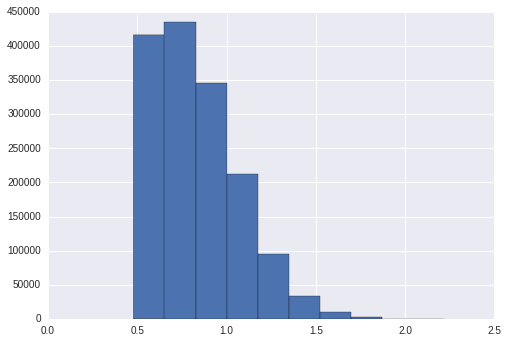

In [19]:
plt.hist(logRich);

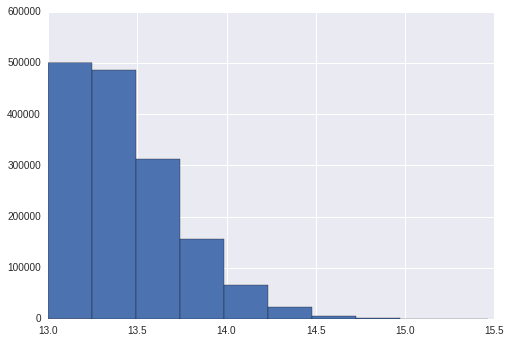

In [20]:
plt.hist(logMass);

In [24]:
from scipy.stats import linregress
b, logA, r, p, err = linregress(logMass, logRich)
print b, 10**logA

0.361541355114 9.41800520701e-05


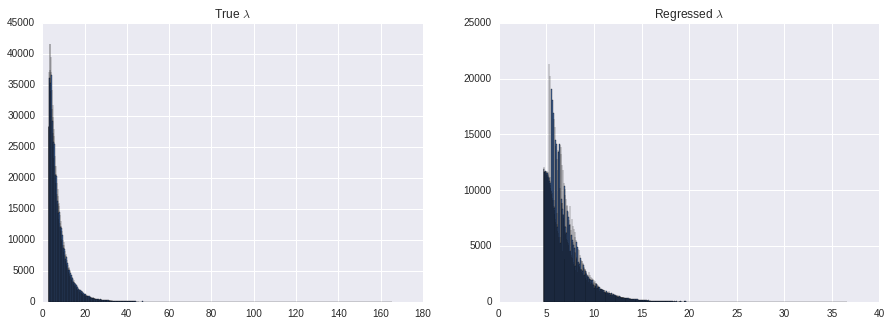

In [33]:
from itertools import cycle
palette = cycle(sns.color_palette())
nBins = int(np.sqrt(rich.shape[0]))
plt.figure(figsize = (15,5))
plt.subplot(121)
plt.title('True $\lambda$')
plt.hist(rich, bins = nBins);
plt.subplot(122)
plt.title('Regressed $\lambda$')
A = 10**logA
plt.hist(A*(data['M200']**b),bins = nBins, color = next(palette));